In [ ]:
import matplotlib.pyplot as plt
from Bio import SeqIO

# === 1. Чтение длин ридов из fasta ===
read_lengths = {}
with open("/content/drive/MyDrive/diploma/filtered_reads.fasta") as fasta_file:
    for record in SeqIO.parse(fasta_file, "fasta"):
        read_lengths[record.id] = len(record.seq)

In [ ]:
# === 2. Чтение позиций из SAM ===
read_alignments = []

with open("/content/drive/MyDrive/diploma/aligned_reads.sam") as sam_file:
    for line in sam_file:
        if line.startswith("@"):  # пропустить заголовки
            continue
        parts = line.strip().split("\t")

        read_id = parts[0]
        ref_pos = int(parts[3])  # позиция на референсе (1-based)

        # Ищем количество несоответствий (тег NM:i:<число>)
        mismatch_count = 0
        for tag in parts[11:]:
            if tag.startswith("NM:i:"):
                mismatch_count = int(tag.split(":")[2])  # Получаем число после NM:i:
                break

        # Если рид есть в read_lengths, добавляем в список
        if read_id in read_lengths:
            read_len = read_lengths[read_id]
            read_alignments.append((read_id, ref_pos, ref_pos + read_len, mismatch_count))

In [ ]:
read_alignments[:10]

[('SRR31296419.4', 4579407, 4579506, 4),
 ('SRR31296419.5', 1979667, 1979765, 6),
 ('SRR31296419.6', 930828, 930927, 4),
 ('SRR31296419.8', 2310828, 2310927, 1),
 ('SRR31296419.12', 931792, 931891, 7),
 ('SRR31296419.15', 2445835, 2445889, 0),
 ('SRR31296419.17', 4725517, 4725614, 0),
 ('SRR31296419.18', 4598339, 4598426, 3),
 ('SRR31296419.19', 1666927, 1667024, 0),
 ('SRR31296419.20', 3666384, 3666482, 0)]

In [ ]:
def merge_intervals(intervals):
    # Сортируем интервалы по начальной позиции
    intervals.sort(key=lambda x: x[1])

    merged = []

    for current in intervals:
        if not merged:
            merged.append(current)
        else:
            # Получаем последний добавленный интервал
            last = merged[-1]

            # Если текущий интервал перекрывается с последним, объединяем их
            if current[1] <= last[2]:
                # Объединяем интервалы и суммируем количество несоответствий
                merged[-1] = (last[0], last[1], max(last[2], current[2]), max(last[3], current[3]))
            else:
                merged.append(current)

    return merged

# Преобразуем список в интервалы, учитывая все элементы
intervals = [(read_id, start, end, ms) for read_id, start, end, ms in read_alignments]

# Получаем объединенные интервалы
merged_intervals = merge_intervals(intervals)

# Выводим результат
for interval in merged_intervals:
    print(interval)

('SRR31296419.123927', 0, 75033, 25)
('SRR31296419.624', 75171, 75380, 12)
('SRR31296419.1087052', 75522, 78080, 9)
('SRR31296419.1741853', 78198, 78550, 8)
('SRR31296419.2275418', 78565, 128913, 78)
('SRR31296419.498765', 129061, 156601, 10)
('SRR31296419.155741', 156625, 188458, 28)
('SRR31296419.178562', 189590, 223959, 25)
('SRR31296419.1439167', 225801, 236212, 12)
('SRR31296419.78441', 236330, 247264, 14)
('SRR31296419.271882', 247319, 276879, 44)
('SRR31296419.162874', 276905, 290902, 10)
('SRR31296419.8860', 290956, 291831, 13)
('SRR31296419.41565', 291875, 292563, 91)
('SRR31296419.86270', 292601, 294395, 14)
('SRR31296419.41290', 294506, 296190, 137)
('SRR31296419.844250', 296259, 306550, 9)
('SRR31296419.59744', 328635, 330426, 6)
('SRR31296419.2261915', 339533, 342358, 29)
('SRR31296419.2006534', 342768, 368927, 63)
('SRR31296419.22038', 369103, 370157, 14)
('SRR31296419.148834', 370524, 370859, 6)
('SRR31296419.1998410', 370864, 420142, 14)
('SRR31296419.65392', 420214, 42

In [ ]:
len(merged_intervals)

219

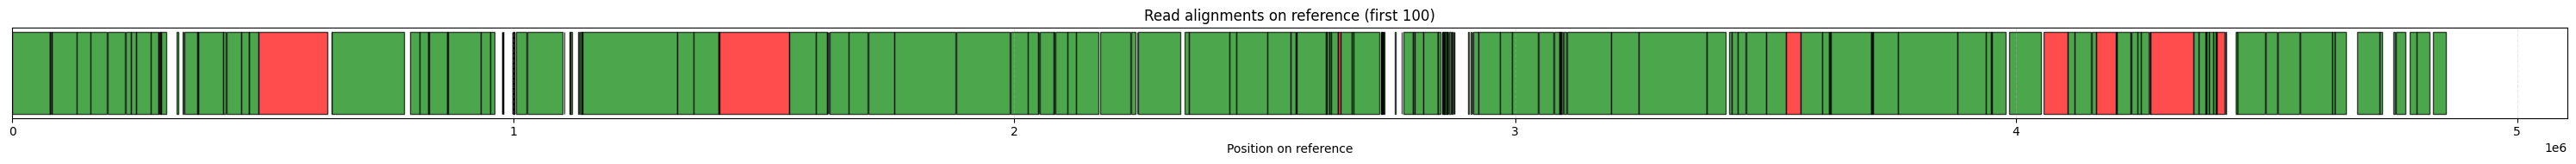

In [ ]:
# === 3. Визуализация ===
plt.figure(figsize=(30, 2))  # Сделаем график более узким по вертикали

# Рисуем все риды на одной оси Y
for idx, (read_id, start, end, mismatches) in enumerate(merged_intervals):
    color = 'green'  # По умолчанию цвет зелёный
    if mismatches > 90:  # Если несоответствий больше 100, красим в красный
        color = 'red'

    plt.barh(0, end - start, left=start, height=0.8, color=color, alpha = 0.7, edgecolor='black')

# Настройка графика
plt.xlabel("Position on reference")
plt.yticks([])  # Убираем метки по оси Y, так как все риды на одной оси
plt.title("Read alignments on reference (first 100)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()

# Показать график
plt.show()

In [ ]:
def calculate_statistics(merged_intervals, reference_length=4857450):
    total_length = 0
    max_length = 0
    total_mismatches = 0
    interval_lengths = []
    total_length_above_90_mismatches = 0

    for _, start, end, mismatches in merged_intervals:
        interval_length = end - start
        total_length += interval_length
        max_length = max(max_length, interval_length)
        total_mismatches += mismatches
        interval_lengths.append(interval_length)

        if mismatches > 90:
            total_length_above_90_mismatches += interval_length

    # Статистика до NGA50/LGA50
    coverage_percentage = (total_length / reference_length) * 100
    mismatches_per_100k = (total_mismatches / total_length) * 100000 if total_length > 0 else 0
    total_intervals = len(merged_intervals)

    # N50
    interval_lengths.sort(reverse=True)
    half_total_length = total_length / 2
    cumulative = 0
    n50 = 0
    for length in interval_lengths:
        cumulative += length
        if cumulative >= half_total_length:
            n50 = length
            break

    # NGA50 и LGA50
    half_reference = reference_length / 2
    cumulative_ref = 0
    nga50 = 0
    lga50 = 0
    for idx, length in enumerate(interval_lengths):
        cumulative_ref += length
        if cumulative_ref >= half_reference:
            nga50 = length
            lga50 = idx + 1  # сколько отрезков потребовалось
            break

    statistics = {
        "Coverage percentage": coverage_percentage,
        "Max interval length": max_length,
        "Total intervals length": total_length,
        "Total mismatches": total_mismatches,
        "Mismatches per 100k": mismatches_per_100k,
        "Total intervals": total_intervals,
        "N50": n50,
        "Total length (mismatches > 90)": total_length_above_90_mismatches,
        "LGA50 (min intervals to cover 50% of reference)": lga50,
        "NGA50 (min interval length for 50% of reference)": nga50
    }

    return statistics


In [ ]:
statistics = calculate_statistics(merged_intervals)

# Выводим статистику
for stat, value in statistics.items():
    print(f"{stat}: {value}")

Coverage percentage: 92.35483638534622
Max interval length: 189639
Total intervals length: 4486090
Total mismatches: 4852
Mismatches per 100k: 108.15654612368454
Total intervals: 219
N50: 53750
Total length (mismatches > 90): 503385
LGA50 (min intervals to cover 50% of reference): 29
NGA50 (min interval length for 50% of reference): 50348
